This is the code used for the remote implementation of the binary classification of images in benign and malignant classes. For the code to run the dataset.csv file should be located at the path '/content/drive/MyDrive/223B/dataset.csv'; the test images should be inside the fold at the path '/content/drive/MyDrive/223B/256_1/256_1_test'; and the train and validation images inside the folder at '/content/drive/MyDrive/223B/256_1/256_1_train'.

Roughly the pipeline in this notebook goes as follows:
- create dictionary based on the csv file with the labels
- create matrices for train, test data
- normalize pixel values in the data and split them into train, validation and test sets
- define lr_schedule
- define ResNet layer
- define ResNetv2 architecture
- subtract mean and convert to categorical
- create function evaluate_network which has x_train, x_val as global variables, returns only the val_acc, and is solely used for the Bayesian Hyperparameter Optimization
- create function create_train_return_model, which fulfills a similar goal as evaluate_network but also retunrs the model, to do manual hyperparameter tuning 
- implement the Bayesian Hyperparameter Optimization to roughly tune the hyperparameters.
- do some further manual tuning of the Hyperparameters using the function create_train_return_model
- plot training history for best model, and evaluate on test set
- make t-SNE plots
- print statements for manual err analysis
- plot accuracy vs image size

In [ ]:
# create dictionary based on the csv file with the labels

import csv

dictio={}

from google.colab import drive
drive.mount('/content/drive')


with open('/content/drive/MyDrive/223B/dataset.csv', newline='') as csvfile:
    sreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in sreader:
        tilename = row[0].split(",")[1]
        cancer = row[0].split(",")[2]
        if cancer=="1" or cancer=="0":
            dictio[tilename]=int(cancer)  


print("\n", dictio)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 {'3637_81536_41216': 1, '6790_14336_17024': 1, '6427_44800_8960': 0, '12166_22400_30464': 0, '3491_121856_35840': 1, '1302_10752_24192': 1, '13225_3584_34944': 0, '7473_9856_18816': 1, '15123_90496_18816': 0, '7309_5376_29568': 0, '1622_44800_16128': 1, '4366_41216_8064': 1, '6820_16128_5376': 1, '10629_8064_19712': 0, '7802_20608_29568': 1, '1588_9856_10752': 1, '6667_72576_24192': 1, '11974_76160_19712': 0, '10398_84224_18816': 0, '8024_69888_31360': 0, '5404_78848_32256': 1, '6292_14336_26880': 1, '3250_72576_17024': 1, '833_3584_47488': 1, '2536_92288_2688': 1, '7521_64512_21504': 0, '820_15232_21504': 0, '11590_15232_27776': 0, '912_49280_1792': 0, '5129_17024_17024': 1, '1150_77952_22400': 1, '5367_35840_49280': 1, '1582_112000_12544': 0, '3640_74368_15232': 0, '352_47488_4928': 0, '8019_97664_8960': 1, '7273_98560_18816': 0, '7265_79744_20608': 1, '7

In [ ]:
# clean up test data

test_pics = []
test_cancer =[]
from imutils import paths
from PIL import Image, ImageFile
# from io import BytesIO
import numpy as np


path_64_1_test = '/content/drive/MyDrive/223B/64_1_copy/64_1_test'
path_128_1_test = '/content/drive/MyDrive/223B/128_1/128_1_test'
path_256_1_test = '/content/drive/MyDrive/223B/256_1/256_1_test'
path_512_test = '/content/drive/MyDrive/223B/512/512_test'

path_new = path_256_1_test
imagePathsNew = list(paths.list_images(path_new))



for imagePath in imagePathsNew:
    # convert images to arrays
    pic = Image.open(imagePath)
    pix = np.array(pic)

    # add array_images to a list
    test_pics.append(np.asarray(pic))
    
    tilenm = imagePath.split("/")[-1][0:-4]
    test_cancer.append(dictio[tilenm])
    

# convert pics list of arrays into a 4D array with or without normalization
# convert cancer into 1D array

test_pics_w_norm = np.array(test_pics) / 127.5 - 1.
test_pics_wo_norm = np.array(test_pics) 

test_cancer = np.array(test_cancer)
test_cancer = test_cancer.reshape((200,1)) 

x_test = test_pics_w_norm
y_test = test_cancer

print(np.shape(x_test), np.shape(y_test), test_cancer[0])



ValueError: ignored

In [ ]:
# clean up train+val data

training_pics = []
training_cancer =[]
from imutils import paths
from PIL import Image, ImageFile
# from io import BytesIO
import numpy as np



path_64_1_train = '/content/drive/MyDrive/223B/64_1_copy/64_1_train'
path_128_1_train = '/content/drive/MyDrive/223B/128_1/128_1_train'
path_256_1_train = '/content/drive/MyDrive/223B/256_1/256_1_train'
path_512_train = '/content/drive/MyDrive/223B/512/512_train'

path_train = path_256_1_train



imagePathsNew = list(paths.list_images(path_train))



for imagePath in imagePathsNew:
    # convert images to arrays
    # print(imagePath)
    pic = Image.open(imagePath)
    pix = np.array(pic)

    # add array_images to a list
    training_pics.append(np.asarray(pic))
    
    tilenm = imagePath.split("/")[-1][0:-4]
    training_cancer.append(dictio[tilenm])
    

# convert pics list of arrays into a 4D array with or without normalization
# convert cancer into 1D array

training_pics_w_norm = np.array(training_pics) / 127.5 - 1.
training_pics_wo_norm = np.array(training_pics) 

training_cancer = np.array(training_cancer)
training_cancer = training_cancer.reshape((800,1)) 

print(np.shape(training_pics), np.shape(training_cancer), training_cancer[0])



(800, 256, 256, 3) (800, 1) [0]


In [ ]:
#create train, validation split

from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import os

# split into train test sets
x_train, x_val, y_train, y_val = train_test_split(training_pics_w_norm, training_cancer, test_size=0.20,  random_state=1)
print(np.shape(x_train),np.shape(y_train) )
print(np.shape(x_val),np.shape(y_val) )

(640, 256, 256, 3) (640, 1)
(160, 256, 256, 3) (160, 1)


In [ ]:
def lr_schedule(epoch, lr_init):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr =  lr_init                           # from heaton 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 800:
        lr *= 1e-4
    elif epoch > 500:
        lr *= 1e-3
    elif epoch > 40:
        lr *= 1e-3
    #print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v2(input_shape, depth, num_units, num_classes=2, droprate=0.33):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is 
    halved (downsampled) by a convolutional layer with 
    strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same
    number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """


    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)
    
    c1 = x

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    z = Dense(num_units,
              activation='relu',
              kernel_initializer='he_normal')(y)

    z = Dropout(droprate)(z)
    z = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(z)
    outputs = z


    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
#subtract mean and to_categorical

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32')
print("before: ", np.shape(x_train) , np.shape(y_train), np.shape(x_val),  np.shape(y_val), np.shape(x_test),  np.shape(y_test)  )
x_val = x_val.astype('float32') 

x_test = x_test.astype('float32') 

NUM_CLASSES = np.unique(y_train).shape[0] # 2
SUBTRACT_PIXEL_MEAN = True

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
    x_val = x_val - x_train_mean


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_val = tensorflow.keras.utils.to_categorical(y_val, NUM_CLASSES)
y_test = tensorflow.keras.utils.to_categorical(y_test, NUM_CLASSES)




before:  (640, 256, 256, 3) (640, 1) (160, 256, 256, 3) (160, 1) (200, 256, 256, 3) (200, 1)
x_train shape: (640, 256, 256, 3)
640 train samples
200 test samples
y_train shape: (640, 1)


In [ ]:
import time
import math
import matplotlib.pyplot as plt
from tensorflow import keras

def evaluate_network( BATCH_SIZE, EPOCHS, dropout, lr_initial):

  # full_evaluate_network has x_tr, y_tr, x_te, y_te, as input 

  x_tr = x_train
  y_tr = y_train
  x_te = x_val
  y_te = y_val

  USE_AUGMENTATION = True
  NUM_CLASSES = np.unique(y_tr).shape[0] # 10
  COLORS = x_tr.shape[3]
  
  depth = (COLORS+3) * 9 + 2 # this depth is meant for resnet_v2
  num_units = 50
  model = resnet_v2(input_shape, depth, num_units, num_classes=2, droprate=dropout)
  # model.compile(loss='categorical_crossentropy',
  #              optimizer=Adam(lr=lr_initial),
  #              metrics=['accuracy'])
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=lr_initial),
                metrics=['accuracy', 'AUC'])
  
  BATCH_SIZE = math.floor(BATCH_SIZE)
  EPOCHS = math.floor(EPOCHS)


  start_time = time.time()

  # Prepare callbacks for model saving and for learning rate adjustment.
  lr_scheduler = LearningRateScheduler(lr_schedule)



  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [lr_reducer, lr_scheduler]

  # Run training, with or without data augmentation.
  if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_tr, y_tr,
               batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_te, y_te),
              shuffle=True,
              callbacks=callbacks)
  else:
    #print('Using real-time data augmentation.')  # **** uncomment?

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_tr)


    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_tr, y_tr, 
                        batch_size=BATCH_SIZE),
                        validation_data=(x_te, y_te),
                        epochs=EPOCHS, verbose=0, workers=1,
                        callbacks=callbacks, 
                        use_multiprocessing=False)




  scores = model.evaluate(x_te, y_te, return_dict=False, verbose=0)
  print(scores)
  tensorflow.keras.backend.clear_session()
  return (scores[1])
  #return (- scores[0])

In [ ]:
import time
import math
import matplotlib.pyplot as plt
from tensorflow import keras

def create_train_return_model( BATCH_SIZE, EPOCHS, dropout, lr_initial):

  # full_evaluate_network has x_tr, y_tr, x_te, y_te, as input 

  x_tr = x_train
  y_tr = y_train
  x_te = x_val
  y_te = y_val

  USE_AUGMENTATION = True
  NUM_CLASSES = np.unique(y_tr).shape[0] # 10
  COLORS = x_tr.shape[3]


  
  depth = (COLORS+3) * 9 + 2 # this depth is meant for resnet_v2
  num_units = 50
  model = resnet_v2(input_shape, depth, num_units, num_classes=2, droprate=dropout)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(lr=lr_initial),
                metrics=['accuracy', 'AUC'])
  # model.compile(loss='categorical_crossentropy',
  #              optimizer=Adam(lr=lr_initial),
  #              metrics=['accuracy'])
  
  BATCH_SIZE = math.floor(BATCH_SIZE)
  EPOCHS = math.floor(EPOCHS)


  start_time = time.time()

  # Prepare callbacks for model saving and for learning rate adjustment.
  lr_scheduler = LearningRateScheduler(lr_schedule)



  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [lr_reducer, lr_scheduler]

  # Run training, with or without data augmentation.
  if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(x_tr, y_tr,
               batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_te, y_te),
              shuffle=True,
              callbacks=callbacks)
  else:
    #print('Using real-time data augmentation.')  # **** uncomment?

    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_tr)


    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_tr, y_tr, 
                        batch_size=BATCH_SIZE),
                        validation_data=(x_te, y_te),
                        epochs=EPOCHS, verbose=1, workers=1,
                        callbacks=callbacks, 
                        use_multiprocessing=False)



  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.ylim([0,2])
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  

  scores = model.evaluate(x_te, y_te, return_dict=False, verbose=0)
  print(scores)
  tensorflow.keras.backend.clear_session()
  return (model, scores[0], scores[1])

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =UserWarning)

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.05, 0.3), 
            'BATCH_SIZE': (7, 12),
            'EPOCHS': (80, 80),
           'lr_initial': (1e-4, 1e-2)
           }



optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=5, n_iter=15,)
time_took = time.time() - start_time

print(time_took)
#print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=907192b5279c9c49fd6975a13c4d51fee6d666cd562c3c43064abba3fb2656fa
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization
|   iter    |  target   | BATCH_... |  EPOCHS   |  dropout  | lr_ini... |
-------------------------------------------------------------------------
[0.4612526297569275, 0.8374999761581421]
|  1        |  0.8375   |  9.085    |  80.0     |  0.05003  |  0.003093 |
[0.506418764591217, 0.8187500238418579]
|  2        |  0.8188   |  7.734    |  80.0     |  0.09657  |  0.003521 |
[1.0066522359848022, 0.8187500238418579]
|  3        |  0.8188   |  8.984    |  80.0     |  0.1548   |  0.006884 |
[0.6419292688369751, 0.831250011920929]
|  4        |  0.8313   |  8.022    |  80.0     |  0.05685  |  0.006738 |
[0.4938718378543854, 0.831250011920929]
|  5        |  0.8313   |

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
32/32 [==============================] - 35s 698ms/step - loss: 5.9674 - accuracy: 0.5257 - auc: 0.5580 - val_loss: 5754.8564 - val_accuracy: 0.5500 - val_auc: 0.5500
Epoch 2/3
32/32 [==============================] - 21s 637ms/step - loss: 1.7984 - accuracy: 0.6916 - auc: 0.7275 - val_loss: 1.6141 - val_accuracy: 0.6500 - val_auc: 0.7161
Epoch 3/3
32/32 [==============================] - 21s 639ms/step - loss: 1.4790 - accuracy: 0.7259 - auc: 0.7880 - val_loss: 1.3259 - val_accuracy: 0.7125 - val_auc: 0.8414


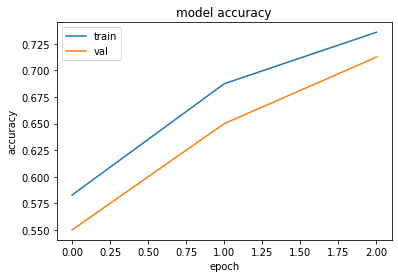

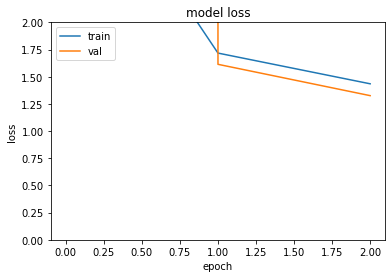

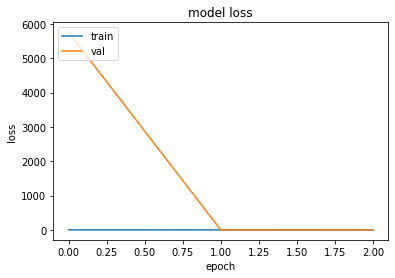

[1.325930118560791, 0.7124999761581421, 0.8414258360862732]
7/7 [==============================] - 3s 260ms/step - loss: 1.3865 - accuracy: 0.6550 - auc: 0.7794
Test loss: 1.3865121603012085
Test accuracy: 0.6549999713897705


In [ ]:
#Continue with some manual hyperparameter tuning

BATCH_SIZE = 20
EPOCHS = 3
dropout = 0.09
lr_initial = 0.003

model_best, loss, accuracy = create_train_return_model( BATCH_SIZE, EPOCHS, dropout, lr_initial)
#evaluate_network( BATCH_SIZE, EPOCHS, dropout, lr_initial)

scores = model_best.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

#model_best.summary()



In [ ]:
#copy here the best and plot and evaluate   
BATCH_SIZE = 54
EPOCHS = 117
dropout = 0.05
lr_initial = 0.00719


model_best, loss, accuracy = create_train_return_model( BATCH_SIZE, EPOCHS, dropout, lr_initial)

scores = model_best.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

model_best.summary()



NameError: ignored

In [ ]:
# T-SNE plot

from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print(model_best.layers[183].name)

# redefine model to output right after the first hidden layer

feat_extr_model = Model(inputs=model_best.inputs, outputs=model_best.layers[183].output)
hidden_features = feat_extr_model.predict(x_test)
hidden_features = hidden_features.reshape( (200, 16*16*256)  )

print('shape of hidden_features is ', np.shape(hidden_features) )

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

color_map = np.argmax(y_test, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()


conv2d_115


ValueError: ignored

In [ ]:
print(np.shape(x_test), np.shape(y_test))
scores = model_best.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


wrong_ct = 0
wrong_list = []

for i in range(np.shape(y_test)[0]):
  x1 = x_test[i,:,:,:]
  y1 = y_test[i]
  x1 = x1.reshape( (1,256,256,3))
  if np.argmax(model_best.predict(x1)[0]) != np.argmax(y1):
    print(np.argmax(model_best.predict(x1)[0]), np.argmax(y1) )
    #print(model_best.predict(x1)[0], y1 )
    #print(i)
    wrong_list.append(i)
    wrong_ct +=1
print(wrong_ct/200)
print(wrong_list)

(200, 256, 256, 3) (200, 2)
7/7 [==============================] - 3s 426ms/step - loss: 3.1117 - accuracy: 0.5500 - auc: 0.6014
Test loss: 3.1116983890533447
Test accuracy: 0.550000011920929
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
0 1
1 0
0 1
0 1
0 1
0 1
0 1
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0.45
[0, 1, 3, 5, 6, 8, 9, 10, 11, 15, 16, 19, 20, 23, 24, 25, 27, 29, 33, 35, 36, 40, 41, 44, 45, 47, 51, 53, 55, 62, 64, 68, 70, 71, 73, 74, 77, 79, 80, 84, 85, 89, 91, 93, 94, 95, 96, 99, 100, 102, 103, 105, 109, 110, 111, 112, 113, 115, 116, 118, 119, 121, 122, 123, 125, 128, 137, 138, 143, 144, 147, 153, 154, 160, 161, 162, 164, 167, 169, 176, 179, 181, 183, 185, 186, 187, 190, 191, 195, 199]


Text(0, 0.5, 'Accuracy')

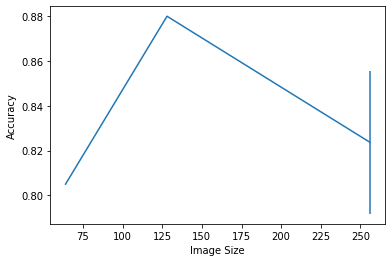

In [ ]:
# plot accuracy vs image size
import matplotlib.pyplot as plt



size = [64, 128, 256]
accuracies_pl = [0.805, 0.880, 0.8237]
e = [0, 0, 0.032]
#e = [0, 0, 0]
plt.errorbar(size, accuracies_pl, yerr=e)
plt.xlabel("Image Size")
plt.ylabel("Accuracy")

